In [325]:
import pandas as pd
import numpy as np
np.random.seed(2018)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import cross_validate

import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import Imputer

import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('whitegrid', {'figure.facecolor': '#CBCBCB'})

# Reading data

In [326]:
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')

df_all = pd.concat([df_train, df_test], sort=True)

# Features

- **PassengerId** - A numerical id assigned to each passenger
- **Survived** - Whether the passenger survived (1), or didn't (0). **Target variable**.
- **Pclass** - Ticket class (1st = Upper, 2nd = Middle, 3rd = Lower)
- **Name** - The name of the passenger
- **Sex** - The gender of the passenger (male or female)
- **Age** - The age of the passenger
- **SibSp** - # of siblings (brother, sister, stepbrother, stepsister) / spouses (husband, wife [mistresses and fiancés were ignored]) aboard the Titanic	
- **Parch** - # of parents (mother, father) / children (daughter, son, stepdaughter, stepson) aboard the Titanic. *Note*: Some children travelled only with a nanny, therefore parch=0 for them..
- **Ticket** - The ticket number of the passenger
- **Fare** - How much the passenger paid for the ticker
- **Cabin** - Cabin number
- **Embarked** - Where the passenger boarded the Titanic Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [327]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [328]:
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [329]:
df_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [330]:
df_all.head(5)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


# Missing data

In [331]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


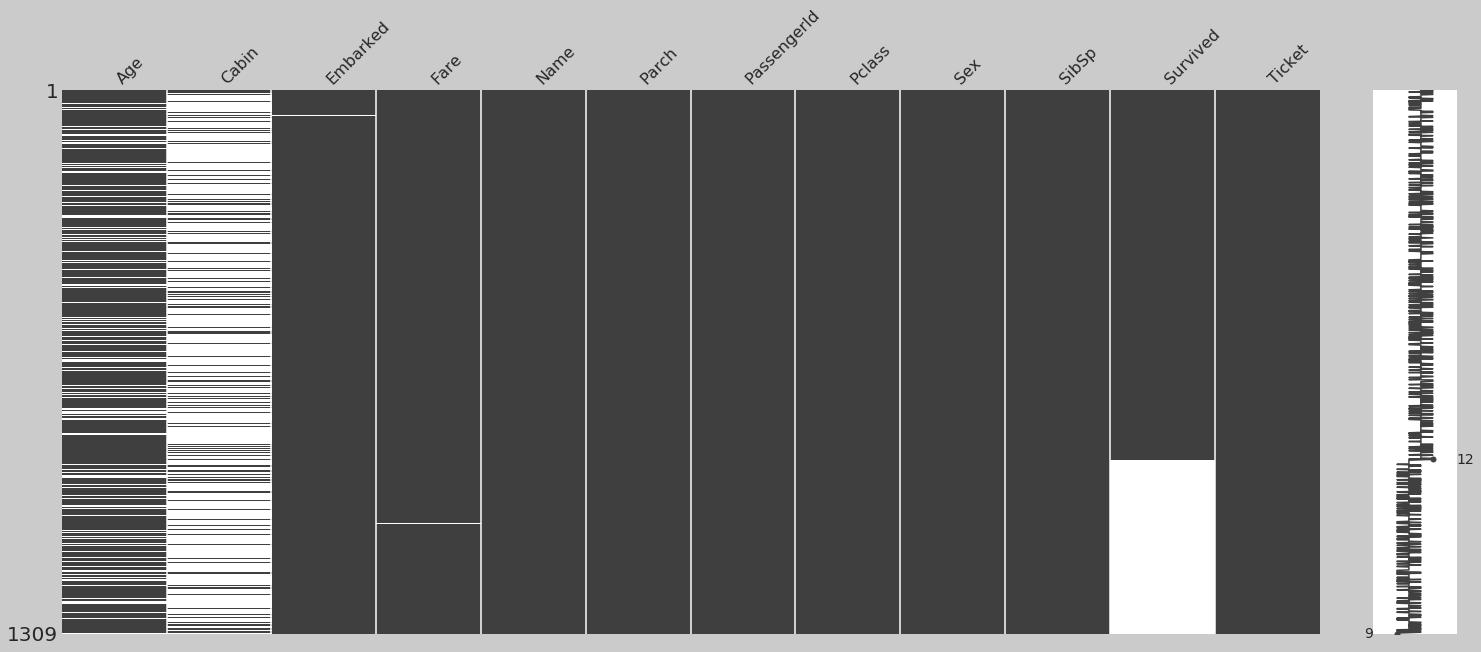

In [332]:
msno.matrix(df_all);

- Age column has missing values with variation in occurrence,
- Cabin column are almost filled with missing values with variation in occurrence, and
- Embarked column has few missing values in the beginning part.

# Looking on dendrogram - influential columns - Cabin and Age

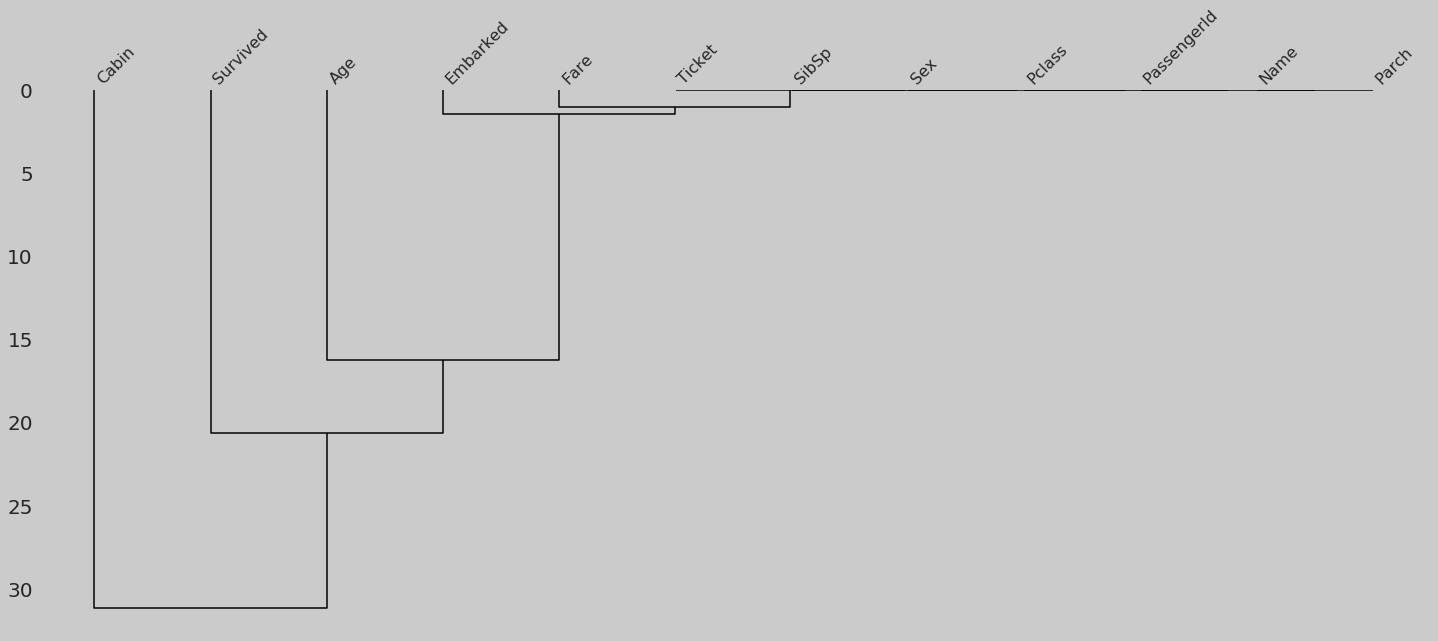

In [333]:
msno.dendrogram(df_all);

# Numerical data

In [334]:
df_all.select_dtypes(include=[np.int, np.float]).head()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
0,22.0,7.2500,0,1,3,1,0.0
1,38.0,71.2833,0,2,1,1,1.0
2,26.0,7.9250,0,3,3,0,1.0
3,35.0,53.1000,0,4,1,1,1.0
4,35.0,8.0500,0,5,3,0,0.0


# Class & Sex & Survived - dependences from train dataset

In [335]:
print(df_train.groupby(["Pclass", "Sex"])["Survived"].value_counts(normalize=True))

Pclass  Sex     Survived
1       female  1           0.968085
                0           0.031915
        male    0           0.631148
                1           0.368852
2       female  1           0.921053
                0           0.078947
        male    0           0.842593
                1           0.157407
3       female  0           0.500000
                1           0.500000
        male    0           0.864553
                1           0.135447
Name: Survived, dtype: float64


# Age & Fare & Pclass & SibSp & Parch - Males & Females - informations from train and test data

In [336]:
describe_fields = ["Age", "Fare", "Pclass", "SibSp", "Parch"]

print("Train: Males")
print(df_train[df_train.Sex == "male"][describe_fields].describe())

print("Test: Males")
print(df_test[df_test.Sex == "male"][describe_fields].describe())

print("Train: Females")
print(df_train[df_train.Sex == "female"][describe_fields].describe())

print("Test: Females")
print(df_test[df_test.Sex == "female"][describe_fields].describe())

Train: Males
              Age        Fare      Pclass       SibSp       Parch
count  453.000000  577.000000  577.000000  577.000000  577.000000
mean    30.726645   25.523893    2.389948    0.429809    0.235702
std     14.678201   43.138263    0.813580    1.061811    0.612294
min      0.420000    0.000000    1.000000    0.000000    0.000000
25%     21.000000    7.895800    2.000000    0.000000    0.000000
50%     29.000000   10.500000    3.000000    0.000000    0.000000
75%     39.000000   26.550000    3.000000    0.000000    0.000000
max     80.000000  512.329200    3.000000    8.000000    5.000000
Test: Males
              Age        Fare      Pclass       SibSp       Parch
count  205.000000  265.000000  266.000000  266.000000  266.000000
mean    30.272732   27.527877    2.334586    0.379699    0.274436
std     13.389528   41.079423    0.808497    0.843735    0.883745
min      0.330000    0.000000    1.000000    0.000000    0.000000
25%     22.000000    7.854200    2.000000    0.0000

# Feature Engineering

## Titles

In [337]:
df_all['Name'].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

# Creating title feature nad normalized title feature
## We can use this code further

In [338]:
def feature_title(df):
    df['title'] = df['Name'].map(lambda x: x.split(',')[1].split('.')[0].lower().strip() )
    
    popular_titles = ["mr", "miss", "mrs", "master", "dr", "rev"]
    
    df['title_norm'] = df['title'].map(lambda x: x if x in popular_titles else "other")
    df['title_norm_cat'] = pd.factorize( df['title_norm'] )[0]
    
    return df

In [339]:
df = feature_title(df_all)
df['title_norm'].value_counts()

mr        757
miss      260
mrs       197
master     61
other      18
dr          8
rev         8
Name: title_norm, dtype: int64

# Cabin


In [340]:
df_all['Cabin'].head(10)

0     NaN
1     C85
2     NaN
3    C123
4     NaN
5     NaN
6     E46
7     NaN
8     NaN
9     NaN
Name: Cabin, dtype: object

In [341]:
df_all['Cabin'].map(lambda x: 'Missing' if str(x) == 'nan' else x[0] ).value_counts()

Missing    1014
C            94
B            65
D            46
E            41
A            22
F            21
G             5
T             1
Name: Cabin, dtype: int64

## Family relationships

In [342]:
df_all.apply(lambda x: x['Parch'] + x['SibSp'], axis=1).value_counts()

0     790
1     235
2     159
3      43
5      25
4      22
6      16
10     11
7       8
dtype: int64

In [343]:
df_train.apply(lambda x: 'NoFamily' if x['Parch'] + x['SibSp'] == 0 else '{0}-{1}'.format(x['Name'].split(',')[0].strip(), x['Parch'] + x['SibSp']), axis=1).value_counts()

NoFamily          537
Andersson-6         8
Sage-10             7
Panula-5            6
Goodwin-7           6
Skoog-5             6
Rice-5              5
Lefebre-4           4
Ford-4              4
Palsson-4           4
Asplund-6           4
Harper-1            4
Carter-3            4
Fortune-5           4
Baclini-3           4
Johnson-2           3
Van Impe-2          3
Navratil-2          3
Allison-3           3
Collyer-2           3
Goldsmith-2         3
Taussig-2           3
Bourke-2            3
Hickman-2           3
Hart-2              3
West-3              3
Thayer-2            3
Laroche-3           3
Hoyt-1              2
McCoy-2             2
                 ... 
Christy-2           1
Persson-1           1
Thomas-1            1
Renouf-3            1
Douglas-1           1
Madill-1            1
Gale-1              1
Cumings-1           1
Richards-5          1
Kiernan-1           1
Frauenthal-2        1
Chronopoulos-1      1
Hold-1              1
Angle-1             1
Cavendish-

## Age

In [344]:
print(df_all.shape)
df_all.Age.describe()

(1309, 15)


count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

In [345]:
df = feature_title(df_all)
df.groupby('title_norm')['Age'].agg([np.mean, np.median])

,mean,median
title_norm,,
dr,43.571429,49.0
master,5.482642,4.0
miss,21.774238,22.0
mr,32.252151,29.0
mrs,36.994118,35.5
other,42.941176,45.0
rev,41.250000,41.5


In [346]:
missing_ages = df.groupby('title_norm')['Age'].agg([np.mean, np.median]).to_dict()['median']
df['Age'] = df.apply( lambda x: x['Age'] if str(x['Age']) != 'nan' else missing_ages[x['title_norm']], axis=1 )

In [347]:
age_bins = [0, 1, 3, 5, 9, 15, 20, 40, 60, 100]
pd.cut(df["Age"], bins=age_bins).astype(object).value_counts()

(20, 40]     824
(40, 60]     196
(15, 20]     133
(9, 15]       33
(60, 100]     33
(5, 9]        26
(3, 5]        23
(0, 1]        22
(1, 3]        19
Name: Age, dtype: int64

## Fare

In [348]:
print(df_all.shape)
df_all['Fare'].describe()

(1309, 15)


count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

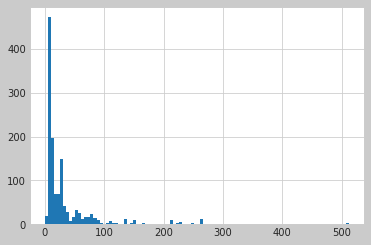

In [349]:
df_all['Fare'].hist(bins=100);

# Normalization - removing outliers

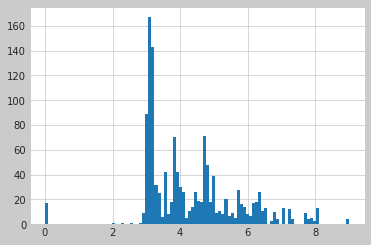

In [350]:
np.log2( df_all['Fare'] + 1 ).hist(bins=100);

# Cabin

In [351]:
df = df_all.copy()

df['Cabin'].unique()
df['cabin_norm'] = df['Cabin'].map(lambda x: 'missing' if str(x) == 'nan' else x[0] )

df.cabin_norm.value_counts()

missing    1014
C            94
B            65
D            46
E            41
A            22
F            21
G             5
T             1
Name: cabin_norm, dtype: int64

In [352]:
def feature_engineering(df):
    df['sex_cat'] = pd.factorize( df['Sex'] )[0]
    df['embarked_cat'] = pd.factorize( df['Embarked'] )[0]
    
    df = feature_title(df)
    
    df['cabin_norm'] = df['Cabin'].map(lambda x: 'missing' if str(x) == 'nan' else x[0] )
    df['cabin_norm_cat'] = pd.factorize( df['cabin_norm'] )[0]
    
    df['family_size'] = df.apply(lambda x: x['Parch'] + x['SibSp'], axis=1)
    df["single"] = df["family_size"].apply(lambda x: 1 if x == 0 else 0)

    df['fare_log'] = np.log2( df['Fare'] + 1 )
    
    missing_ages = df.groupby('title_norm')['Age'].agg([np.mean, np.median]).to_dict()['median']
    df['Age'] = df.apply( lambda x: x['Age'] if str(x['Age']) != 'nan' else missing_ages[x['title_norm']], axis=1 )
    
    age_bins = [0, 1, 3, 5, 9, 15, 20, 40, 60, 100]
    df['age_bin'] = pd.factorize( pd.cut(df["Age"], bins=age_bins).astype(object) )[0]

    return df

In [364]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
df_all['_AgeImputer'] = imp.fit_transform(df_all[['Age']])
df_all['_FareImputer'] = imp.fit_transform(df_all[['Fare']])

In [368]:
def get_feats(df):
    feats = df.select_dtypes(include=[np.float, np.int]).columns.values
    black_list = ['PassengerId', 'Survived', 'Fare']
    
    return [feat for feat in feats if feat not in black_list]


def feature_engineering(df):
    df['sex_cat'] = pd.factorize( df['Sex'] )[0]
    df['embarked_cat'] = pd.factorize( df['Embarked'] )[0]
    
    return df

df = feature_engineering(df_all)
feats = get_feats(df)
print(feats)

['Age', 'Parch', 'Pclass', 'SibSp', 'title_norm_cat', '_AgeImputer', 'sex_cat', 'embarked_cat', '_FareImputer']


In [369]:
df_all.head(3)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,title,title_norm,title_norm_cat,_AgeImputer,sex_cat,embarked_cat,_FareImputer
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,mr,mr,0,22.0,0,0,7.2500
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,mrs,mrs,1,38.0,1,1,71.2833
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,miss,miss,2,26.0,1,0,7.9250


In [376]:
#for column in df.columns:
    print(column, df[column].unique())

IndentationError: unexpected indent (<ipython-input-376-dacae83cd804>, line 2)

In [371]:
def get_models():
    return [
        ('linear reg', LinearRegression()),
      #  ('logistic regr', LogisticRegression()),
      #  ('decisoin tree', DecisionTreeClassifier()),
      #  ('random forest', RandomForestClassifier()),
     #   ('extra tree classifirer', ExtraTreesClassifier()),
    ]

In [372]:
def plot_result(model_name, result, ylim=(0, 1.)):
    mean_train = np.round( np.mean(result['train_score']), 2 )
    mean_test = np.round( np.mean(result['test_score']), 2 )
    
    plt.title('{0}: cross validation\nmean-train-acc:{1}\nmean-test-acc:{2}'.format(model_name, mean_train, mean_test))
    plt.plot( result['train_score'], 'r-o', label="train" )
    plt.plot( result['test_score'], 'g-o', label="test" )
    plt.legend(loc='best')
    plt.ylabel('Accuracy')
    plt.xlabel('# of fold')
    plt.ylim(*ylim)
    plt.show()

In [373]:
#df_all.Fare.unique()

In [374]:
df = feature_engineering(df_train)
get_feats(df)

X = df_train[ get_feats(df_train) ].values
y = df_train[ 'Survived' ].values

for model_name, model in get_models():
    result = cross_validate(model, X, y, scoring='accuracy', cv=3, return_train_score=True)
    print(model_name)

    plot_result(model_name, result)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
for max_depth in range(2, 18, 1):
    model = RandomForestClassifier(max_depth=max_depth, n_estimators=12)
    result = cross_validate(model, X, y, scoring='accuracy', cv=6, return_train_score=True)
    plot_result("Decision Tree: max_depth=%s" % max_depth, result)